## Training 1b

- Was hoping to not have to train myself, but not super surprised that I need to. ]
- Starting here: https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20#scrollTo=Jpfq01sZyPdC

In [1]:
seed=2

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

# import comet_ml
import itertools

In [3]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient 
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x

In [4]:
# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component 
# - I expect this wasn't necessary or particularly important, and a bunch of this 
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

In [5]:
# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

def test_logits(logits, bias_correction=False, original_logits=None, mode='all'):
    # Calculates cross entropy loss of logits representing a batch of all p^2 
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1]==p*p:
        logits = logits.T
    if logits.shape==torch.Size([p*p, p+1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p*p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms, 
        # independent of the input, by centering the new logits along the batch 
        # dimension, and then adding the average original logits across all inputs
        logits = einops.reduce(original_logits - logits, 'batch ... -> ...', 'mean') + logits
    if mode=='train':
        return cross_entropy_high_precision(logits[is_train], labels[is_train])
    elif mode=='test':
        return cross_entropy_high_precision(logits[is_test], labels[is_test])
    elif mode=='all':
        return cross_entropy_high_precision(logits, labels)

In [6]:
#Plotting functions
# This is mostly a bunch of over-engineered mess to hack Plotly into producing 
# the pretty pictures I want, I recommend not reading too closely unless you 
# want Plotly hacking practice
def to_numpy(tensor, flat=False):
    if type(tensor)!=torch.Tensor:
        return tensor
    if flat:
        return tensor.flatten().detach().cpu().numpy()
    else:
        return tensor.detach().cpu().numpy()
def imshow(tensor, xaxis=None, yaxis=None, animation_name='Snapshot', **kwargs):
    if tensor.shape[0]==p*p:
        tensor = unflatten_first(tensor)
    tensor = torch.squeeze(tensor)
    px.imshow(to_numpy(tensor, flat=False), 
              labels={'x':xaxis, 'y':yaxis, 'animation_name':animation_name}, 
              **kwargs).show()
# Set default colour scheme
imshow = partial(imshow, color_continuous_scale='Blues')
# Creates good defaults for showing divergent colour scales (ie with both 
# positive and negative values, where 0 is white)
imshow_div = partial(imshow, color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
# Presets a bunch of defaults to imshow to make it suitable for showing heatmaps 
# of activations with x axis being input 1 and y axis being input 2.
inputs_heatmap = partial(imshow, xaxis='Input 1', yaxis='Input 2', color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
def line(x, y=None, hover=None, xaxis='', yaxis='', **kwargs):
    if type(y)==torch.Tensor:
        y = to_numpy(y, flat=True)
    if type(x)==torch.Tensor:
        x=to_numpy(x, flat=True)
    fig = px.line(x, y=y, hover_name=hover, **kwargs)
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()
def scatter(x, y, **kwargs):
    px.scatter(x=to_numpy(x, flat=True), y=to_numpy(y, flat=True), **kwargs).show()
def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    # Helper function to plot multiple lines
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()
def line_marker(x, **kwargs):
    lines([x], mode='lines+markers', **kwargs)
def animate_lines(lines_list, snapshot_index = None, snapshot='snapshot', hover=None, xaxis='x', yaxis='y', **kwargs):
    if type(lines_list)==list:
        lines_list = torch.stack(lines_list, axis=0)
    lines_list = to_numpy(lines_list, flat=False)
    if snapshot_index is None:
        snapshot_index = np.arange(lines_list.shape[0])
    if hover is not None:
        hover = [i for j in range(len(snapshot_index)) for i in hover]
    print(lines_list.shape)
    rows=[]
    for i in range(lines_list.shape[0]):
        for j in range(lines_list.shape[1]):
            rows.append([lines_list[i][j], snapshot_index[i], j])
    df = pd.DataFrame(rows, columns=[yaxis, snapshot, xaxis])
    px.line(df, x=xaxis, y=yaxis, animation_frame=snapshot, range_y=[lines_list.min(), lines_list.max()], hover_name=hover,**kwargs).show()

def imshow_fourier(tensor, title='', animation_name='snapshot', facet_labels=[], **kwargs):
    # Set nice defaults for plotting functions in the 2D fourier basis
    # tensor is assumed to already be in the Fourier Basis
    if tensor.shape[0]==p*p:
        tensor = unflatten_first(tensor)
    tensor = torch.squeeze(tensor)
    fig=px.imshow(to_numpy(tensor),
            x=fourier_basis_names, 
            y=fourier_basis_names, 
            labels={'x':'x Component', 
                    'y':'y Component', 
                    'animation_frame':animation_name},
            title=title,
            color_continuous_midpoint=0., 
            color_continuous_scale='RdBu', 
            **kwargs)
    fig.update(data=[{'hovertemplate':"%{x}x * %{y}y<br>Value:%{z:.4f}"}])
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label
    fig.show()

def animate_multi_lines(lines_list, y_index=None, snapshot_index = None, snapshot='snapshot', hover=None, swap_y_animate=False, **kwargs):
    # Can plot an animation of lines with multiple lines on the plot.
    if type(lines_list)==list:
        lines_list = torch.stack(lines_list, axis=0)
    lines_list = to_numpy(lines_list, flat=False)
    if swap_y_animate:
        lines_list = lines_list.transpose(1, 0, 2)
    if snapshot_index is None:
        snapshot_index = np.arange(lines_list.shape[0])
    if y_index is None:
        y_index = [str(i) for i in range(lines_list.shape[1])]
    if hover is not None:
        hover = [i for j in range(len(snapshot_index)) for i in hover]
    print(lines_list.shape)
    rows=[]
    for i in range(lines_list.shape[0]):
        for j in range(lines_list.shape[2]):
            rows.append(list(lines_list[i, :, j])+[snapshot_index[i], j])
    df = pd.DataFrame(rows, columns=y_index+[snapshot, 'x'])
    px.line(df, x='x', y=y_index, animation_frame=snapshot, range_y=[lines_list.min(), lines_list.max()], hover_name=hover, **kwargs).show()

def animate_scatter(lines_list, snapshot_index = None, snapshot='snapshot', hover=None, yaxis='y', xaxis='x', color=None, color_name = 'color', **kwargs):
    # Can plot an animated scatter plot
    # lines_list has shape snapshot x 2 x line
    if type(lines_list)==list:
        lines_list = torch.stack(lines_list, axis=0)
    lines_list = to_numpy(lines_list, flat=False)
    if snapshot_index is None:
        snapshot_index = np.arange(lines_list.shape[0])
    if hover is not None:
        hover = [i for j in range(len(snapshot_index)) for i in hover]
    if color is None:
        color = np.ones(lines_list.shape[-1])
    if type(color)==torch.Tensor:
        color = to_numpy(color)
    if len(color.shape)==1:
        color = einops.repeat(color, 'x -> snapshot x', snapshot=lines_list.shape[0])
    print(lines_list.shape)
    rows=[]
    for i in range(lines_list.shape[0]):
        for j in range(lines_list.shape[2]):
            rows.append([lines_list[i, 0, j].item(), lines_list[i, 1, j].item(), snapshot_index[i], color[i, j]])
    print([lines_list[:, 0].min(), lines_list[:, 0].max()])
    print([lines_list[:, 1].min(), lines_list[:, 1].max()])
    df = pd.DataFrame(rows, columns=[xaxis, yaxis, snapshot, color_name])
    px.scatter(df, x=xaxis, y=yaxis, animation_frame=snapshot, range_x=[lines_list[:, 0].min(), lines_list[:, 0].max()], range_y=[lines_list[:, 1].min(), lines_list[:, 1].max()], hover_name=hover, color=color_name, **kwargs).show()

In [7]:
def unflatten_first(tensor):
    if tensor.shape[0]==p*p:
        return einops.rearrange(tensor, '(x y) ... -> x y ...', x=p, y=p)
    else: 
        return tensor
def cos(x, y):
    return (x.dot(y))/x.norm()/y.norm()
def mod_div(a, b):
    return (a*pow(b, p-2, p))%p
def normalize(tensor, axis=0):
    return tensor/(tensor).pow(2).sum(keepdim=True, axis=axis).sqrt()
def extract_freq_2d(tensor, freq):
    # Takes in a pxpx... or batch x ... tensor, returns a 3x3x... tensor of the 
    # Linear and quadratic terms of frequency freq
    tensor = unflatten_first(tensor)
    # Extracts the linear and quadratic terms corresponding to frequency freq
    index_1d = [0, 2*freq-1, 2*freq]
    # Some dumb manipulation to use fancy array indexing rules
    # Gets the rows and columns in index_1d
    return tensor[[[i]*3 for i in index_1d], [index_1d]*3]
def get_cov(tensor, norm=True):
    # Calculate covariance matrix
    if norm:
        tensor = normalize(tensor, axis=1)
    return tensor @ tensor.T
def is_close(a, b):
    return ((a-b).pow(2).sum()/(a.pow(2).sum().sqrt())/(b.pow(2).sum().sqrt())).item()

In [8]:
def compute_frequency_components(m):
    """
    Compute canonical frequency components of a real 2D signal m using fft2.

    Returns:
        components: list of dicts with keys:
            - 'kx': frequency index in x (rows)
            - 'ky': frequency index in y (cols)
            - 'coeff': complex FFT coefficient at (kx, ky)
        Nx, Ny: dimensions of the input
    """
    m = np.asarray(m)
    Nx, Ny = m.shape
    F = np.fft.fft2(m)

    components = []
    seen = set()

    for kx in range(Nx):
        for ky in range(Ny):
            # Conjugate partner indices for real-valued input
            kx_conj = (-kx) % Nx
            ky_conj = (-ky) % Ny

            pair = tuple(sorted([(kx, ky), (kx_conj, ky_conj)]))
            if pair in seen:
                continue
            seen.add(pair)

            # Always store the "smaller" one in lexicographic order
            kx_rep, ky_rep = pair[0]
            coeff = F[kx_rep, ky_rep]
            components.append({
                "kx": kx_rep,
                "ky": ky_rep,
                "coeff": coeff
            })

    return components, Nx, Ny


def components_to_terms(components, Nx, Ny, num_freqs, include_dc=True):
    """
    Convert FFT components into real cosine terms with amplitude & phase.

    Args:
        components: output from compute_frequency_components
        Nx, Ny: grid size
        num_freqs: number of *non-DC* frequencies to keep
        include_dc: whether to include the constant (DC) term

    Returns:
        terms: list of dicts with keys:
            - 'kx', 'ky'
            - 'amplitude'  (real, >= 0)
            - 'phase'      (in radians)
            - 'is_dc'      (bool, True only for the constant term)
    """
    terms = []
    dc_term = None

    for c in components:
        kx = c["kx"]
        ky = c["ky"]
        coeff = c["coeff"]

        # DC component (constant offset)
        if kx == 0 and ky == 0:
            dc_value = coeff.real / (Nx * Ny)
            dc_term = {
                "kx": 0,
                "ky": 0,
                "amplitude": dc_value,  # directly the constant offset
                "phase": 0.0,
                "is_dc": True,
            }
        else:
            # For real signals, combine (k, l) and (-k, -l) into:
            #   2*|F|/(Nx*Ny) * cos(2π(kx i/Nx + ky j/Ny) + phase)
            amp = 2.0 * np.abs(coeff) / (Nx * Ny)
            phase = np.angle(coeff)
            terms.append({
                "kx": kx,
                "ky": ky,
                "amplitude": amp,
                "phase": phase,
                "is_dc": False,
            })

    # Sort non-DC terms by amplitude (largest first)
    terms.sort(key=lambda t: t["amplitude"], reverse=True)

    # Keep only the top num_freqs
    terms = terms[:num_freqs]

    # Optionally prepend DC term
    if include_dc and dc_term is not None:
        terms = [dc_term] + terms

    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit 1D and product-of-cosine terms from a sparse Fourier representation.

    Types of terms:
      - DC term (constant)
      - Row-only:   A * cos(2π * (kx*i/Nx) + φ)
      - Col-only:   B * cos(2π * (ky*j/Ny) + φ)
      - Product:    C * cos(2π * (kx*i/Nx) + φ) * cos(2π * (ky*j/Ny) + φ)

    You must have `import numpy as np` in the scope where you paste/run this.
    """
    lines = []
    lines.append(f"def {func_name}(i, j):")

    if not terms:
        lines.append("    return 0.0")
        return "\n".join(lines)

    # Separate DC from others
    dc_terms = [t for t in terms if t.get("is_dc", False)]
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]

    if dc_terms:
        dc_val = round(dc_terms[0]["amplitude"], decimals)
        lines.append(f"    val = {dc_val}")
    else:
        lines.append("    val = 0.0")

    for t in non_dc_terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        if kx != 0 and ky == 0:
            # Row-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
            )
        elif kx == 0 and ky != 0:
            # Column-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )
        else:
            # Product-of-cosines term (your desired "third" type)
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
                f" * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )

        lines.append(line)

    lines.append("    return val")

    return "\n".join(lines)

In [9]:
def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For all CUDA devices
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Set to False for determinism

In [10]:
def compute_freq_penalty(model, p, lambda_freq=0.01):
    """
    Penalize high-frequency components in the embedding matrix.
    """
    # W_E shape: (d_model, d_vocab)
    # We only care about the first p columns (the numbers 0 to p-1, not the = token)
    W_E_numbers = model.embed.W_E[:, :p]  # (d_model, p)
    
    # FFT along the token dimension
    fft = torch.fft.fft(W_E_numbers, dim=1)
    fft_mag_sq = torch.abs(fft) ** 2
    
    # Frequency indices: 0, 1, 2, ..., p-1
    # But due to periodicity, freq k and p-k are equivalent
    # So "effective" frequency is min(k, p-k)
    freqs = torch.arange(p, device=W_E_numbers.device, dtype=torch.float32)
    freqs = torch.minimum(freqs, p - freqs)  # now in range [0, p//2]
    
    # Quadratic weight: penalize freq k proportional to k^2
    weights = freqs ** 2
    
    # Sum over all embedding dimensions and frequencies
    penalty = (weights[None, :] * fft_mag_sq).sum()
    
    return lambda_freq * penalty

In [11]:
lambda_freq = 0.0 #1e-8  # <- tune this; start here and adjust

frac_train=0.3 #0.28 might be more interesting
p=113
# seed=2 ##Set at top

lr=1e-3 #@param
weight_decay = 1.0 #@param
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
num_epochs = 12000 #@param
save_models = False #@param
save_every = 100 #@param
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param

num_layers = 1
batch_style = 'full'
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# batch_size = 512
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]

In [12]:
frac_train, seed

(0.3, 2)

In [13]:
def gen_train_test(frac_train, num, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train, test = gen_train_test(frac_train, p, seed)
print(len(train), len(test))

3830 8939


In [14]:
# Creates an array of Boolean indices according to whether each data point is in 
# train or test
# Used to index into the big batch of all possible data
is_train = []
is_test = []
for x in range(p):
    for y in range(p):
        if (x, y, 113) in train:
            is_train.append(True)
            is_test.append(False)
        else:
            is_train.append(False)
            is_test.append(True)
is_train = np.array(is_train)
is_test = np.array(is_test)

In [15]:
set_seed(seed)
model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
model.to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
run_name = f"grok_{int(time.time())}"
print(f'Run name {run_name}')
if save_models:
    os.mkdir(root/run_name)
    save_dict = {'model':model.state_dict(), 'train_data':train, 'test_data':test}
    torch.save(save_dict, root/run_name/'init.pth')
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = full_loss(model, train)
    test_loss = full_loss(model, test)

    freq_penalty = compute_freq_penalty(model, p, lambda_freq)
    total_loss = train_loss + freq_penalty
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    if epoch%100 == 0: print(f"{epoch}_{np.log(train_loss.item()):.4f}_{np.log(test_loss.item()):.4f}")#_{train_acc.item():.4f}_{test_acc.item():.4f}")
    total_loss.backward()
    
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    if test_loss.item() < stopping_thresh:
        break
    if (save_models) and (epoch%save_every == 0):
        if test_loss.item() < stopping_thresh:
            break
        save_dict = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'epoch': epoch,
        }
        torch.save(save_dict, root/run_name/f"{epoch}.pth")
        print(f"Saved model to {root/run_name/f'{epoch}.pth'}")
# if not save_models:
#     os.mkdir(root/run_name)
# save_dict = {
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
#     'scheduler': scheduler.state_dict(),
#     'train_loss': train_loss,
#     'test_loss': test_loss,
#     'train_losses': train_losses,
#     'test_losses': test_losses,
#     'epoch': epoch,
# }
# torch.save(save_dict, root/run_name/f"final.pth")
# print(f"Saved model to {root/run_name/f'final.pth'}")
# lines([train_losses, test_losses], labels=['train', 'test'], log_y=True)

# save_models = False

Run name grok_1764099469
0_1.5605_1.5598
100_0.7538_2.0533
200_-3.9246_2.7230
300_-4.9700_2.7370
400_-6.0965_2.7737
500_-7.2015_2.8109
600_-8.2915_2.8468
700_-9.3681_2.8803
800_-10.4289_2.9108
900_-11.4654_2.9369
1000_-12.4523_2.9584
1100_-13.3428_2.9730
1200_-14.0654_2.9789
1300_-14.5617_2.9746
1400_-14.8278_2.9601
1500_-14.9302_2.9382
1600_-14.9607_2.9122
1700_-14.9726_2.8840
1800_-14.9815_2.8542
1900_-14.9903_2.8230
2000_-14.9994_2.7898
2100_-15.0103_2.7535
2200_-15.0216_2.7136
2300_-15.0346_2.6694
2400_-15.0483_2.6191
2500_-15.0630_2.5622
2600_-15.0790_2.4974
2700_-15.0964_2.4232
2800_-15.1158_2.3360
2900_-15.1384_2.2329
3000_-15.1662_2.1077
3100_-15.1966_1.9552
3200_-15.2332_1.7682
3300_-15.2735_1.5315
3400_-15.3193_1.2362
3500_-15.3707_0.8676
3600_-15.4229_0.4122
3700_-15.4768_-0.1231
3800_-15.5305_-0.7261
3900_-15.5805_-1.3664
4000_-15.6282_-2.0241
4100_-15.6735_-2.7072
4200_-15.7163_-3.4122
4300_-15.7526_-4.0344
4400_-15.7836_-4.5897
4500_-15.8113_-5.1234
4600_-15.8381_-5.5840


In [16]:
len(train_losses)

12000

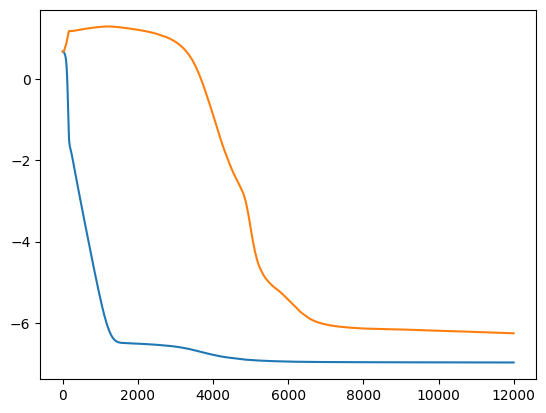

In [17]:
plt.plot(np.log10(train_losses)); plt.plot(np.log10(test_losses))

In [18]:
# plt.plot(train_losses); plt.plot(test_losses)

Ok, how to quickly find frequencies?

In [19]:
all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)
# Final position only
original_logits = model(all_data)[:, -1]
# Remove equals sign from output logits
original_logits = original_logits[:, :-1]
original_loss = cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item()}")

Original loss: 4.1786362095680404e-07


In [20]:
for k in cache.keys():
    print(k, cache[k].shape)

blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_k torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_q torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_v torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_attn_pre torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_attn torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 4, 3, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [21]:
#Ok let's try pre -> the og. 
mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy() 
mr.shape

(113, 113, 3, 512)

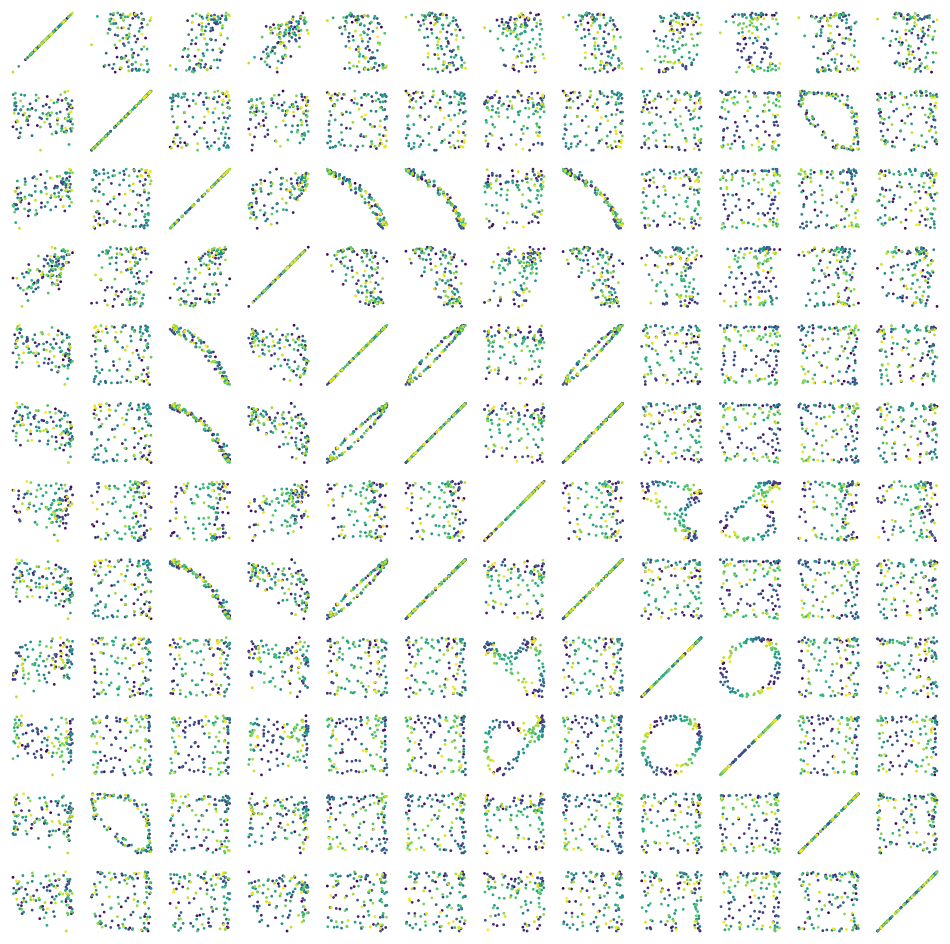

In [22]:
fig=plt.figure(0, (12,12))
for i in range(12):
    for j in range(12):
        fig.add_subplot(12,12,12*i+j+1)
        plt.scatter(mr[:, 0, 2, i], mr[:, 0, 2, j], c=range(113), s=1)
        plt.axis('off')

In [23]:
neuron_idx=0
F = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 1.287
    val += 0.14 * np.cos(2*np.pi*((38*i)/113) + 2.638) * np.cos(2*np.pi*((38*j)/113) + 2.638)
    val += 0.138 * np.cos(2*np.pi*((27*i)/113) + 1.525) * np.cos(2*np.pi*((27*j)/113) + 1.525)
    val += 0.107 * np.cos(2*np.pi*((7*i)/113) + 2.072) * np.cos(2*np.pi*((7*j)/113) + 2.072)
    val += 0.106 * np.cos(2*np.pi*((27*i)/113) + 0.0) * np.cos(2*np.pi*((86*j)/113) + 0.0)
    return val


In [24]:
neuron_idx=1
F = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 0.272
    val += 1.751 * np.cos(2*np.pi*((6*i)/113) + 1.616)
    val += 1.745 * np.cos(2*np.pi*((6*j)/113) + 1.616)
    val += 0.145 * np.cos(2*np.pi*((12*i)/113) + 0.272)
    val += 0.144 * np.cos(2*np.pi*((12*j)/113) + 0.271)
    return val


- Woah 3 and 6?! Damn I should have cached indemediate results!
- If they actually show up for cross terms of course

In [25]:
neuron_idx=2
F = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 0.637
    val += 2.169 * np.cos(2*np.pi*((7*i)/113) + 1.72)
    val += 2.154 * np.cos(2*np.pi*((7*j)/113) + 1.723)
    val += 0.381 * np.cos(2*np.pi*((7*i)/113) + -2.627) * np.cos(2*np.pi*((7*j)/113) + -2.627)
    val += 0.211 * np.cos(2*np.pi*((14*i)/113) + 0.548)
    return val


In [26]:
neuron_idx=5
F = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 0.83
    val += 2.052 * np.cos(2*np.pi*((7*i)/113) + -1.155)
    val += 2.049 * np.cos(2*np.pi*((7*j)/113) + -1.157)
    val += 0.556 * np.cos(2*np.pi*((7*i)/113) + -2.267) * np.cos(2*np.pi*((7*j)/113) + -2.267)
    val += 0.256 * np.cos(2*np.pi*((14*j)/113) + 0.86)
    return val


In [27]:
def approx_M(i, j):
    val = 0.216
    val += 0.073 * np.cos(2*np.pi*((20*i)/113) + 1.604) * np.cos(2*np.pi*((20*j)/113) + 1.604)
    val += 0.044 * np.cos(2*np.pi*((51*i)/113) + 2.097) * np.cos(2*np.pi*((51*j)/113) + 2.097)
    val += 0.037 * np.cos(2*np.pi*((20*i)/113) + 3.142) * np.cos(2*np.pi*((93*j)/113) + 3.142)
    val += 0.036 * np.cos(2*np.pi*((40*i)/113) + -1.563)
    return val

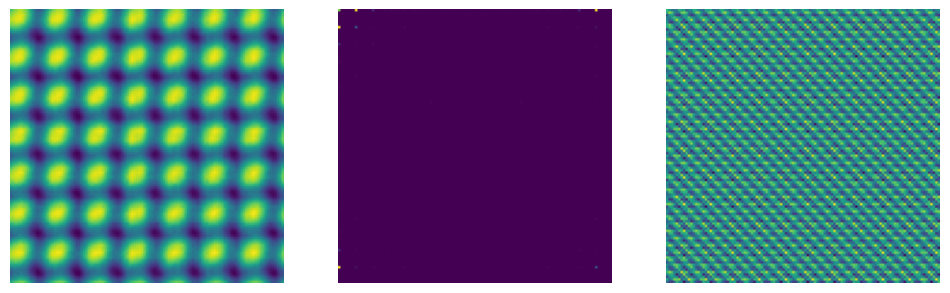

In [28]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=approx_M(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(F));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(m_approx); plt.axis('off');

20 Might be better!

In [29]:
for neuron_idx in range(32):
    F = np.fft.fft2(mr[:,:,2,neuron_idx])
    
    components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
    terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
    code_str = generate_python_reconstructor(terms, Nx, Ny,
                                             func_name="approx_M",
                                             decimals=3)
    print(neuron_idx, code_str)

0 def approx_M(i, j):
    val = 1.287
    val += 0.14 * np.cos(2*np.pi*((38*i)/113) + 2.638) * np.cos(2*np.pi*((38*j)/113) + 2.638)
    val += 0.138 * np.cos(2*np.pi*((27*i)/113) + 1.525) * np.cos(2*np.pi*((27*j)/113) + 1.525)
    val += 0.107 * np.cos(2*np.pi*((7*i)/113) + 2.072) * np.cos(2*np.pi*((7*j)/113) + 2.072)
    val += 0.106 * np.cos(2*np.pi*((27*i)/113) + 0.0) * np.cos(2*np.pi*((86*j)/113) + 0.0)
    return val
1 def approx_M(i, j):
    val = 0.272
    val += 1.751 * np.cos(2*np.pi*((6*i)/113) + 1.616)
    val += 1.745 * np.cos(2*np.pi*((6*j)/113) + 1.616)
    val += 0.145 * np.cos(2*np.pi*((12*i)/113) + 0.272)
    val += 0.144 * np.cos(2*np.pi*((12*j)/113) + 0.271)
    return val
2 def approx_M(i, j):
    val = 0.637
    val += 2.169 * np.cos(2*np.pi*((7*i)/113) + 1.72)
    val += 2.154 * np.cos(2*np.pi*((7*j)/113) + 1.723)
    val += 0.381 * np.cos(2*np.pi*((7*i)/113) + -2.627) * np.cos(2*np.pi*((7*j)/113) + -2.627)
    val += 0.211 * np.cos(2*np.pi*((14*i)/113) + 0.548)
 